DATA PROCESSING

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms


# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Create instances of the DataLoader class
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=64, num_workers=2)


# Extract the input data and target labels
X_train, y_train = train_data.data, train_data.targets
X_test, y_test = test_data.data, test_data.targets
# Print the shapes of the input data and target labels
print('train_X shape:', X_train.shape)
print('train_Y shape:', y_train.shape)
print('test_X shape:', X_test.shape)
print('test_Y shape:', y_test.shape)

for inputs, targets in train_loader:
    print(inputs.shape)
    print(targets.shape)
    break  # to print only the first batch

for input, target in test_loader:
    print(input.shape)
    print(target.shape)
    break  # to print only the first batch

100%|██████████| 561753746/561753746 [00:21<00:00, 25653100.70it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
train_X shape: torch.Size([112800, 28, 28])
train_Y shape: torch.Size([112800])
test_X shape: torch.Size([18800, 28, 28])
test_Y shape: torch.Size([18800])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 1, 28, 28])
torch.Size([64])


BASELINE

In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import time

start_time = time.time()

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)


# Create instances of the DataLoader class
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=64, num_workers=2)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*7*7, 47)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x
        from sklearn.model_selection import KFold

# Define the train function
def train(model, train_loader, criterion, optimizer):
    model.train()
    for images, labels in train_loader:
        # Move data to GPU
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler = torch.optim.lr_scheduler.stepLR(optimizer, step_size=5,gamma=0.1)

# Define the evaluate function
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to GPU
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


# Define the number of folds
n_splits = 5

# Create a list to store the validation accuracies for each fold
accuracies = []

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Create the KFold object
kf = KFold(n_splits=n_splits, shuffle=True)
# Loop over the folds
for fold, (train_indices, val_indices) in enumerate(kf.split(train_data)):
    # Get the training and validation data for this fold
    train_subset = torch.utils.data.Subset(train_data, train_indices)
    val_subset = torch.utils.data.Subset(train_data, val_indices)

    # Create the data loaders for this fold
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)

    # Create a new instance of the CNN model and move it to GPU
    model = CNN().to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Train the model for n_epochs epochs on this fold's training data
    n_epochs = 5
    for epoch in range(n_epochs):
        train(model, train_loader, criterion, optimizer)

    # Evaluate the model on this fold's validation data
    accuracy = evaluate(model, val_loader)

    # Append the validation accuracy to the list of accuracies
    accuracies.append(accuracy)

    
    # Print the current accuracy for this fold
    print(f"Fold {fold}: Validation accuracy = {accuracy}")
    
# Calculate the average accuracy across all folds
avg_accuracy = sum(accuracies) / len(accuracies)

# Print the average accuracy
print(f"Average accuracy across {n_splits} folds = {avg_accuracy}")





Using device: cuda
Fold 0: Validation accuracy = 86.875
Fold 1: Validation accuracy = 87.46897163120568
Fold 2: Validation accuracy = 86.98581560283688
Fold 3: Validation accuracy = 86.72872340425532
Fold 4: Validation accuracy = 87.15868794326241
Average accuracy across 5 folds = 87.04343971631207


In [ ]:
#learning rate scheduler

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import time

start_time = time.time()
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*7*7, 47)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x

# Define the number of epochs
num_epochs = 5

# Define the number of folds
k = 5

# Create a KFold object
kf = KFold(n_splits=k)

# Define a list to store the validation accuracies for each fold
val_accuracies = []

# Define the learning rate scheduling methods
schedulers = [
    ("StepLR", torch.optim.lr_scheduler.StepLR, {"step_size": 5, "gamma": 0.1}),
    ("MultiStepLR", torch.optim.lr_scheduler.MultiStepLR, {"milestones": [5, 10, 15], "gamma": 0.1}),
    ("CosineAnnealingLR", torch.optim.lr_scheduler.CosineAnnealingLR, {"T_max": 5, "eta_min": 0.001})
]

# Define a dictionary to store the average validation accuracies for each scheduler
scheduler_avg_val_accuracies = {}

# Iterate over the learning rate scheduling methods
for name, scheduler_cls, params in schedulers:
    # Define a list to store the validation accuracies for each fold
    fold_val_accuracies = []

    # Iterate over the folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_data)):
        # Split the data into training and validation sets for this fold
        train_dataset = torch.utils.data.Subset(train_data, train_indices)
        val_dataset = torch.utils.data.Subset(train_data, val_indices)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

        # Define the model, optimizer, and loss function
        model = CNN()
        optimizer = optim.Adam(model.parameters())
        
        criterion = nn.CrossEntropyLoss()

        # Train the model on the training set for this fold
        val_accuracies = []
        for epoch in range(num_epochs):
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data, target
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

            # Evaluate the model on the validation set for this fold
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for data, target in val_loader:
                    data, target = data, target
                    outputs = model(data)
                    _, predicted = torch.max(outputs.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

                accuracy = 100 * correct / total
                print(f"Scheduler: {name}, Fold: {fold+1}, Validation Accuracy: {accuracy:.2f}%", flush=True)
            # Store the validation accuracy for this fold
            val_accuracies.append(accuracy)
             
        # Store the average validation accuracy for this fold
        fold_val_accuracies.append(sum(val_accuracies) / len(val_accuracies))

    # Store the average validation accuracies for this scheduler
    scheduler_avg_val_accuracies[name] = sum(fold_val_accuracies) / len(fold_val_accuracies)

# Print the average validation accuracies for each scheduler
for name, avg_val_accuracy in scheduler_avg_val_accuracies.items():
    print(f"Average validation accuracy for {name}: {avg_val_accuracy:.2f}%")

# Print the best scheduler based on the highest average validation accuracy
best_scheduler = max(scheduler_avg_val_accuracies, key=scheduler_avg_val_accuracies.get)
print(f"The best scheduler is {best_scheduler} with an average validation accuracy of {scheduler_avg_val_accuracies[best_scheduler]:.2f}%")
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.

Scheduler: StepLR, Fold: 1, Validation Accuracy: 84.23%
Scheduler: StepLR, Fold: 1, Validation Accuracy: 86.04%
Scheduler: StepLR, Fold: 1, Validation Accuracy: 86.84%
Scheduler: StepLR, Fold: 1, Validation Accuracy: 86.72%
Scheduler: StepLR, Fold: 1, Validation Accuracy: 86.68%
Scheduler: StepLR, Fold: 2, Validation Accuracy: 83.85%
Scheduler: StepLR, Fold: 2, Validation Accuracy: 86.09%
Scheduler: StepLR, Fold: 2, Validation Accuracy: 86.50%
Scheduler: StepLR, Fold: 2, Validation Accuracy: 87.38%
Scheduler: StepLR, Fold: 2, Validation Accuracy: 87.23%
Scheduler: StepLR, Fold: 3, Validation Accuracy: 84.40%
Scheduler: StepLR, Fold: 3, Validation Accuracy: 86.02%
Scheduler: StepLR, Fold: 3, Validation Accuracy: 86.95%
Scheduler: StepLR, Fold: 3, Validation Accuracy: 86.85%
Scheduler: StepLR, Fold: 3, Validation Accuracy: 86.91%
Scheduler: StepLR, Fold: 4, Validation Accuracy: 84.56%
Scheduler: StepLR, Fold: 4, Validation Accuracy: 86.34%
Scheduler: StepLR, Fold: 4, Validation Accuracy:

activation_functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import math

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, activation_fn):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.activation1 = activation_fn
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.activation2 = activation_fn
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*7*7, 47)

    def forward(self, x):
        x = self.pool1(self.activation1(self.bn1(self.conv1(x))))
        x = self.pool2(self.activation2(self.bn2(self.conv2(x))))
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x

# Define the number of epochs
num_epochs = 5

# Define the number of folds
k = 5
# Define the batch size, number of workers
batch_size = 64
num_workers = 2
lr = 0.01
momentum = 0.9
weight_decay = 1e-4
# Define some constants
num_iters_per_epoch = 100


# Define the activation functions to use
activation_functions = [
    ("ReLU", nn.ReLU()),
    ("LeakyReLU", nn.LeakyReLU()),
    ("ELU", nn.ELU())
]
# Choose an activation function
activation_fn = nn.ReLU()

# Create the CNN model with the chosen activation function
model = CNN(activation_fn)

# Initialize variables to store the average validation accuracy for each activation function
avg_val_accs = {}
for activation_fn_name, _ in activation_functions:
    avg_val_accs[activation_fn_name] = 0

# Define a dictionary to store the average validation accuracy for each activation function
avg_val_acc = {activation_fn_name: 0.0 for activation_fn_name, _ in activation_functions}

# Define the overall best activation function and its average validation accuracy
best_activation_fn_name = ""
best_avg_val_acc = 0.0

# Define the learning rate scheduler
def cosine_scheduler(optimizer, lr_init, num_epochs, num_iters_per_epoch):
    def _scheduler(epoch):
        return lr_init * 0.5 * (1 + math.cos(epoch * math.pi / num_epochs))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, _scheduler)

    return scheduler

# Move the model to GPU
model.to(device)

# Iterate over the folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for fold, (train_indices, val_indices) in enumerate(kf.split(train_data)):
    # Split the data into training and validation sets for this fold
    train_dataset = torch.utils.data.Subset(train_data, train_indices)
    val_dataset = torch.utils.data.Subset(train_data, val_indices)

    # Define the data loaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    # Define the optimizer and the learning rate scheduler
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = cosine_scheduler(optimizer,lr, num_epochs, num_iters_per_epoch) 
    criterion = nn.CrossEntropyLoss()

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Move the data to GPU
            data, target = data.to(device), target.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()

        # Adjust the learning rate
        scheduler.step()

        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                # Move the data to GPU
                data, target = data.to(device), target.to(device)

                # Forward pass
                output = model(data)
                val_loss += criterion(output, target).item()

                # Compute the number of correct predictions
                pred = output.argmax(dim=1, keepdim=True)
                val_correct += pred.eq(target.view_as(pred)).sum().item()

        # Compute the average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_correct / len(val_loader.dataset)

        # Print the results for this epoch
        print("Fold: {} Epoch: {} Val Loss: {:.6f} Val Acc: {:.2f}%".format(fold, epoch+1, avg_val_loss, avg_val_acc*100))

        # Update the best activation function and its average validation accuracy
        if avg_val_acc > best_avg_val_acc:
            best_avg_val_acc = avg_val_acc
            best_activation_fn_name = activation_fn.__class__.__name__

# Print the overall best activation function and its average validation accuracy
print("Best Activation Function: {} Best Avg Val Acc: {:.2f}%".format(best_activation_fn_name, best_avg_val_acc*100))


Using device: cuda
Fold: 0 Epoch: 1 Val Loss: 1.134477 Val Acc: 70.51%
Fold: 0 Epoch: 2 Val Loss: 0.862729 Val Acc: 76.06%
Fold: 0 Epoch: 3 Val Loss: 0.770252 Val Acc: 78.12%
Fold: 0 Epoch: 4 Val Loss: 0.734854 Val Acc: 78.85%
Fold: 0 Epoch: 5 Val Loss: 0.725539 Val Acc: 79.24%
Fold: 1 Epoch: 1 Val Loss: 0.645622 Val Acc: 81.04%
Fold: 1 Epoch: 2 Val Loss: 0.608832 Val Acc: 81.74%
Fold: 1 Epoch: 3 Val Loss: 0.584269 Val Acc: 82.55%
Fold: 1 Epoch: 4 Val Loss: 0.575683 Val Acc: 82.70%
Fold: 1 Epoch: 5 Val Loss: 0.571325 Val Acc: 82.82%
Fold: 2 Epoch: 1 Val Loss: 0.553881 Val Acc: 83.28%
Fold: 2 Epoch: 2 Val Loss: 0.536137 Val Acc: 83.69%
Fold: 2 Epoch: 3 Val Loss: 0.527515 Val Acc: 83.86%
Fold: 2 Epoch: 4 Val Loss: 0.521420 Val Acc: 84.10%
Fold: 2 Epoch: 5 Val Loss: 0.520386 Val Acc: 84.08%
Fold: 3 Epoch: 1 Val Loss: 0.493941 Val Acc: 84.86%
Fold: 3 Epoch: 2 Val Loss: 0.483978 Val Acc: 84.95%
Fold: 3 Epoch: 3 Val Loss: 0.479181 Val Acc: 85.07%
Fold: 3 Epoch: 4 Val Loss: 0.476786 Val Acc: 

optimizers

In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import time

start_time = time.time()

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)


# Create instances of the DataLoader class
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=64, num_workers=2)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*7*7, 47)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x

optimizers = {
    'SGD': torch.optim.SGD,
    'ADAM': torch.optim.Adam,
    'RMSprop': torch.optim.RMSprop,
    'ASGD': torch.optim.ASGD
}

# Set the hyperparameters
lr = 0.001
k = 5
num_epochs = 5


# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


# Create a dictionary to store the validation accuracy for each optimizer, fold, and epoch
val_acc_dict = {}
for optimizer_name in optimizers:
    val_acc_dict[optimizer_name] = []

# Apply k-fold cross-validation for each optimizer
for optimizer_name, optimizer_fn in optimizers.items():
    print(f'Optimizer: {optimizer_name}')
    for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=k, shuffle=True, random_state=42).split(train_data)):
        print(f'Fold [{fold+1}/{k}]')

        # Initialize the model, optimizer, and scheduler for the current fold
        model = CNN().to(device)
        optimizer = optimizer_fn(model.parameters(), lr=lr)
        
        num_batches = len(train_loader) * num_epochs
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_batches)
        train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(train_idx)
        )
        val_loader = torch.utils.data.DataLoader(
            train_data, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(val_idx)
        )
        criterion = nn.CrossEntropyLoss()

        # Train the model for the specified number of epochs
               # Train the model for the specified number of epochs
        for epoch in range(num_epochs):
            train_loss = 0
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                output = model(images.to(device))
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * images.size(0)
            train_loss /= len(train_loader.dataset)

            # Compute the validation loss and accuracy
            val_loss = 0
            val_correct = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    val_correct += (predicted == labels).sum().item()
                val_loss /= len(val_loader.sampler)
                val_acc = val_correct / len(val_loader.sampler)
                val_acc_dict[optimizer_name].append(val_acc) # store validation accuracy for the current fold and epoch
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            # Update the learning rate using MultiStepLR
            scheduler.step()

# Compute the average validation accuracy for each optimizer
for optimizer_name in optimizers:
    val_acc = sum(val_acc_dict[optimizer_name]) / (k * num_epochs)
    print(f'Optimizer: {optimizer_name}, Average Validation Accuracy: {val_acc*100:.2f}%')

optimizer_val_acc = {}
for optimizer_name in optimizers:
    val_acc = sum(val_acc_dict[optimizer_name]) / (k * num_epochs)
    optimizer_val_acc[optimizer_name] = val_acc

# Print the best optimizer
best_optimizer = max(optimizer_val_acc, key=optimizer_val_acc.get)
print(f'Best optimizer: {best_optimizer}, Average Validation Accuracy: {optimizer_val_acc[best_optimizer]*100:.2f}%')

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

       


Using device: cuda
Optimizer: SGD
Fold [1/5]
Epoch [1/5], Train Loss: 1.5234, Validation Loss: 1.1647, Validation Accuracy: 0.7006
Epoch [2/5], Train Loss: 0.7909, Validation Loss: 0.8727, Validation Accuracy: 0.7567
Epoch [3/5], Train Loss: 0.6351, Validation Loss: 0.7401, Validation Accuracy: 0.7851
Epoch [4/5], Train Loss: 0.5562, Validation Loss: 0.6685, Validation Accuracy: 0.8033
Epoch [5/5], Train Loss: 0.5080, Validation Loss: 0.6232, Validation Accuracy: 0.8151
Fold [2/5]
Epoch [1/5], Train Loss: 1.4826, Validation Loss: 1.1362, Validation Accuracy: 0.7054
Epoch [2/5], Train Loss: 0.7726, Validation Loss: 0.8397, Validation Accuracy: 0.7668
Epoch [3/5], Train Loss: 0.6187, Validation Loss: 0.7180, Validation Accuracy: 0.7920
Epoch [4/5], Train Loss: 0.5432, Validation Loss: 0.6473, Validation Accuracy: 0.8096
Epoch [5/5], Train Loss: 0.4972, Validation Loss: 0.6046, Validation Accuracy: 0.8195
Fold [3/5]
Epoch [1/5], Train Loss: 1.5055, Validation Loss: 1.1317, Validation Accu

WITH BATCH NORMALIZE

In [ ]:
##WITH BATCH NORMALIZE
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import torch.nn.functional as F
import time


# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)
# # Create instances of the DataLoader class
# train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=64, num_workers=2)
# test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=64, num_workers=2)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*7*7, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x


# Define the data loaders
batch_size = 32
lr = 0.01
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Training with RMSprop optimizer and CosineAnnealingLR learning rate scheduler")
# Define the data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


# Apply k-fold cross-validation
accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"Fold [{fold+1}/{kf.n_splits}]")
   
    # Initialize the model, optimizer, and scheduler for the current fold
    model = CNN().to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    num_batches = len(train_loader) * num_epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_batches)

    # Define the data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

    # Set the optimizer to RMSprop and the learning rate scheduler to cosine annealing

optimizer = optim.RMSprop(model.parameters(), lr=lr)
num_batches = len(train_loader) * num_epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_batches)

# Train the model for the current fold
for epoch in range(num_epochs):
    # Train for one epoch
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # Validate the model for one epoch
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
        # Compute the accuracy for the current fold
        val_loss /= len(val_loader.dataset)
        accuracy = 100. * correct / total
        accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss:.4f} | Accuracy WitH batch normalization: {accuracy:.2f}%")
    # Calculate the accuracy for the current fold and add it to the list of accuracies
    fold_acc = 100 * correct / total
    accuracies.append(fold_acc)

# Calculate the average accuracy over all folds
avg_acc = sum(accuracies) / len(accuracies)
print(f"Average Accuracy: {avg_acc:.2f}%")



Training with RMSprop optimizer and CosineAnnealingLR learning rate scheduler
Fold [1/5]
Fold [2/5]
Fold [3/5]
Fold [4/5]
Fold [5/5]
Epoch [1/5] | Validation Loss: 0.0926 | Accuracy WitH batch normalization: 84.71%
Epoch [2/5] | Validation Loss: 0.0811 | Accuracy WitH batch normalization: 86.35%
Epoch [3/5] | Validation Loss: 0.0754 | Accuracy WitH batch normalization: 87.13%
Epoch [4/5] | Validation Loss: 0.0730 | Accuracy WitH batch normalization: 87.55%
Epoch [5/5] | Validation Loss: 0.0735 | Accuracy WitH batch normalization: 87.81%
Average Accuracy: 86.71%


regularization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import torch.nn.functional as F
import time

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*7*7, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x

# Define the data loaders
batch_size = 32
lr = 0.01
num_epochs = 5
# Set learning rate and momentum
learning_rate = 0.01
momentum = 0.9
# Instantiate the model
model = CNN()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

# Define the cross-validation folds
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define dictionaries to store the average accuracy for each regularization method
none_acc = []
l1_acc = []
l2_acc = []
regularization_methods = {
    'none': None,
    'l1': 0.0001,
    'l2': 0.0001
}

# Loop over the regularization methods
for reg_name, reg_value in regularization_methods.items():
    print('Using regularization method:', reg_name)

    # Define lists to store accuracy for each fold
    fold_none_acc = []
    fold_l1_acc = []
    fold_l2_acc = []

    # Loop over the cross-validation folds
    for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(train_data)):
        print('Using fold', fold_idx)

        # Create data loaders for training and validation sets
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)
        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

        # Move model and data to device
        model.to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        num_batches = len(train_loader) * num_epochs
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_batches)
  
        # Define optimizer with or without regularization
        if reg_value is None:
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        elif reg_name == 'l1':
            optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=reg_value)
        elif reg_name == 'l2':
            optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=reg_value, momentum=0.9)

        # Train the model
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                if reg_value is not None:
                    l1_reg = reg_value * torch.norm(model.fc.weight, p=1)
                    l2_reg = reg_value * torch.norm(model.fc.weight, p=2)
                    loss = loss + l1_reg + l2_reg
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                

            # Compute accuracy on validation set
            model.eval()
            valid_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    valid_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
                    
            valid_loss /= len(valid_loader)
            accuracy = 100 * correct / total
            
            # Store accuracy for each fold
            if reg_value is None:
                fold_none_acc.append(accuracy)
            elif reg_name == 'l1':
                fold_l1_acc.append(accuracy)
            elif reg_name == 'l2':
                fold_l2_acc.append(accuracy)

            print(f"Fold {fold_idx+1}: Train loss = {train_loss:.3f}, Validation loss = {valid_loss:.3f}, Validation accuracy = {accuracy:.2f}% for {reg_name} regularization")
#      # Calculate average accuracy for each regularization method

if len(fold_none_acc) > 0:
    none_avg_acc = sum(fold_none_acc) / len(fold_none_acc)
    print(f"Average validation accuracy with no regularization: {none_avg_acc:.2f}%")

if len(fold_l1_acc) > 0:
    l1_avg_acc = sum(fold_l1_acc) / len(fold_l1_acc)
    print(f"Average validation accuracy with L1 regularization (lambda={reg_value}): {l1_avg_acc:.2f}%")

if len(fold_l2_acc) > 0:
    l2_avg_acc = sum(fold_l2_acc) / len(fold_l2_acc)
    print(f"Average validation accuracy with L2 regularization (lambda={reg_value}): {l2_avg_acc:.2f}%")
        
    


Using device: cuda
Using regularization method: none
Using fold 0
Fold 1: Train loss = 2896.210, Validation loss = 0.430, Validation accuracy = 85.44% for none regularization
Fold 1: Train loss = 1200.666, Validation loss = 0.414, Validation accuracy = 86.07% for none regularization
Fold 1: Train loss = 1089.864, Validation loss = 0.417, Validation accuracy = 86.36% for none regularization
Fold 1: Train loss = 1033.723, Validation loss = 0.397, Validation accuracy = 86.72% for none regularization
Fold 1: Train loss = 1001.844, Validation loss = 0.406, Validation accuracy = 86.45% for none regularization
Using fold 1
Fold 2: Train loss = 1070.375, Validation loss = 0.353, Validation accuracy = 87.96% for none regularization
Fold 2: Train loss = 1012.414, Validation loss = 0.369, Validation accuracy = 87.08% for none regularization
Fold 2: Train loss = 985.818, Validation loss = 0.392, Validation accuracy = 87.03% for none regularization
Fold 2: Train loss = 959.623, Validation loss = 0.

with dropout

In [ ]:
#with dropout

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc = nn.Linear(64*7*7, 47)
        self.bn_fc = nn.BatchNorm1d(47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        x = self.bn_fc(x)
        return x



# Define the data loaders
batch_size = 32
lr = 0.01
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Training with RMSprop optimizer and CosineAnnealingLR learning rate scheduler")

# Apply k-fold cross-validation for dropout
accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"Fold [{fold+1}/{kf.n_splits}]")


    # Initialize the model, optimizer, and scheduler for the current fold
    model = CNN().to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    num_batches = len(train_loader) * num_epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_batches)

    # Define the data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
    
    # Add dropout to the model
    model.drop1 = nn.Dropout(p=0.2)
    model.drop2 = nn.Dropout(p=0.2)
    
    # Train the model for the current fold
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Accuracy: {accuracy:.2f}%")
            
# Evaluate the model on the test set for the current fold
model.eval()
with torch.no_grad():
    test_loader = DataLoader(test_data, batch_size=batch_size)
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Fold [{fold+1}/{kf.n_splits}] Test Accuracy: {accuracy:.2f}%")
    accuracies.append(accuracy)

# Calculate the average test accuracy over all folds
    average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Test Accuracy: {average_accuracy:.2f}%")



Training with RMSprop optimizer and CosineAnnealingLR learning rate scheduler
Fold [1/5]
Fold [2/5]
Fold [3/5]
Fold [4/5]
Fold [5/5]
Epoch [5/5] Validation Accuracy: 88.31%
Fold [5/5] Test Accuracy: 87.74%
Average Test Accuracy: 87.74%


without dropout

In [ ]:
#without dropout
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*7*7, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x


# Define the data loaders
batch_size = 32
lr = 0.01
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Training with RMSprop optimizer and CosineAnnealingLR learning rate scheduler witout dropout")

# Apply k-fold cross-validation without dropout
accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"Fold [{fold+1}/{kf.n_splits}]")

    # Initialize the model, optimizer, and scheduler for the current fold
    model = CNN().to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    num_batches = len(train_loader) * num_epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_batches)

    # Define the data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

    # Train the model for the current fold
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}] Validation Accuracy: {accuracy:.2f}%")

        # Evaluate the model on the test set for the current fold
        model.eval()
        with torch.no_grad():
            test_loader = DataLoader(test_data, batch_size=batch_size)
            correct = 0
            total = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print(f"Fold [{fold+1}/{kf.n_splits}] Test Accuracy: {accuracy:.2f}%")

            accuracies.append(accuracy)

print(f"Overall Test Accuracy: {sum(accuracies)/len(accuracies):.2f}%")


Training with RMSprop optimizer and CosineAnnealingLR learning rate scheduler witout dropout
Fold [1/5]
Epoch [1/5] Validation Accuracy: 84.31%
Fold [1/5] Test Accuracy: 84.04%
Epoch [2/5] Validation Accuracy: 86.94%
Fold [1/5] Test Accuracy: 86.30%
Epoch [3/5] Validation Accuracy: 87.41%
Fold [1/5] Test Accuracy: 86.98%
Epoch [4/5] Validation Accuracy: 88.01%
Fold [1/5] Test Accuracy: 87.45%
Epoch [5/5] Validation Accuracy: 88.15%
Fold [1/5] Test Accuracy: 87.56%
Fold [2/5]
Epoch [1/5] Validation Accuracy: 85.45%
Fold [2/5] Test Accuracy: 85.08%
Epoch [2/5] Validation Accuracy: 86.45%
Fold [2/5] Test Accuracy: 86.57%
Epoch [3/5] Validation Accuracy: 87.04%
Fold [2/5] Test Accuracy: 86.68%
Epoch [4/5] Validation Accuracy: 87.69%
Fold [2/5] Test Accuracy: 87.52%
Epoch [5/5] Validation Accuracy: 87.78%
Fold [2/5] Test Accuracy: 87.65%
Fold [3/5]
Epoch [1/5] Validation Accuracy: 84.56%
Fold [3/5] Test Accuracy: 84.19%
Epoch [2/5] Validation Accuracy: 86.31%
Fold [3/5] Test Accuracy: 86.32

FIND THE BEST NUMBER OF NEURONS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import time
import torch.nn.functional as F


# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

import torch

# Define the device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

class CNN(nn.Module):
    def __init__(self, hidden_neurons):
        super(CNN, self).__init__()
        self.hidden_neurons = hidden_neurons
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc = nn.Linear(64*7*7, self.hidden_neurons)
        self.bn_fc = nn.BatchNorm1d(self.hidden_neurons)
        self.output = nn.Linear(self.hidden_neurons, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        x = self.bn_fc(x)
        x = self.output(x)
        return x


# Set up the cross-validation
k = 5
num_epochs=5
hidden_neurons_list = [34, 64, 128, 512, 1024]
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Train and evaluate the model for each value of hidden_neurons
best_hidden_neurons = None
best_accuracy = 0.0
for hidden_neurons in hidden_neurons_list:
    accuracy_list = []
    for fold, (train_index, val_index) in enumerate(kf.split(train_data)):
        # Split the data into training and validation sets for this fold
        train_subset = torch.utils.data.Subset(train_data, train_index)
        val_subset = torch.utils.data.Subset(train_data, val_index)
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=True)

        # Initialize the model, optimizer, and scheduler for the current fold and hidden neuron value
        model = CNN(hidden_neurons)
        model.to(device)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        criterion = nn.CrossEntropyLoss()

            # Train the model for the current fold
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        # Adjust the learning rate using the scheduler
        scheduler.step()

        # Evaluate the model on the validation set for this fold
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        # Compute the average training and validation accuracy for this fold and epoch
        train_accuracy = train_correct / len(train_subset)
        val_accuracy = val_correct / len(val_subset)
        accuracy_list.append(val_accuracy)

# Compute the average validation accuracy across all folds for this hidden neuron value
avg_accuracy = sum(accuracy_list) / len(accuracy_list)

# Update the best hidden neuron value and accuracy if this value is better than the previous best
if avg_accuracy > best_accuracy:
    best_hidden_neurons = hidden_neurons
    best_accuracy = avg_accuracy
print(f"Best number of hidden neurons: {best_hidden_neurons}")
print(f"Best validation accuracy on the validation set: {best_accuracy:.4f}")

cuda
Best number of hidden neurons: 1024
Best validation accuracy on the validation set: 0.8374


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import KFold

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU is not available, using CPU instead')

class CNN(nn.Module):
    def __init__(self, num_hidden_layers, hidden_neurons):
        super(CNN, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.hidden_neurons = hidden_neurons
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.2)
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            if i == 0:
                input_size = 64 * 7 * 7
            else:
                input_size = hidden_neurons
            self.hidden_layers.append(nn.Linear(input_size, hidden_neurons))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_neurons))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(p=0.2))
        self.output = nn.Linear(hidden_neurons, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 64*7*7)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output(x)
        return x

# Define range of values for number of hidden layers
hidden_layer_sizes = [1, 2, 3, 4, 5]

# Set up k-fold cross-validation
k = 5
num_epochs = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
hidden_neurons = 1024

# Initialize lists to record results
accuracies = []
best_num_hidden_layers = None
best_accuracy = 0.0


# Start timer
start_time = time.time()

for num_hidden_layers in hidden_layer_sizes:
    fold_accuracies = []
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_data)):
        # Split data into train and validation sets
        train_subset = torch.utils.data.Subset(train_data, train_indices)
        val_subset = torch.utils.data.Subset(train_data, val_indices)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)


        # Initialize the model, optimizer, and scheduler for the current fold and hidden neuron value
        model = CNN(num_hidden_layers, hidden_neurons).to(device)
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        criterion = nn.CrossEntropyLoss()
            # Train the model
        # Train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute validation accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        fold_accuracies.append(accuracy)

# Compute average validation accuracy for this number of hidden layers
avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
accuracies.append(avg_accuracy)

# Check if this is the best accuracy so far
if avg_accuracy > best_accuracy:
    best_accuracy = avg_accuracy
    best_num_hidden_layers = num_hidden_layers


print(f"Best number of hidden layers: {best_num_hidden_layers}")
print(f"Best validation accuracy: {best_accuracy}")
print(f"Time taken: {time.time()-start_time} seconds")






GPU is available
Best number of hidden layers: 5
Best validation accuracy: 0.8356294326241134
Time taken: 900.2361905574799 seconds


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import KFold
import sklearn.metrics
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU is not available, using CPU instead')

class CNN(nn.Module):
    def __init__(self, num_hidden_layers, hidden_neurons):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(1024, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.relu5 = nn.ReLU()
        self.drop5 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(1024, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(1024, 47)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.drop4(x)
        x = self.fc3(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.drop5(x)
        x = self.fc4(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.drop6(x)
        x = self.fc5(x)
        return x

# Set up k-fold cross-validation
k = 5
num_epochs = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the model, optimizer, and scheduler for the current fold and hidden neuron value
# Initialize the model, optimizer, and scheduler for the current fold and hidden neuron value
model = CNN(num_hidden_layers=3, hidden_neurons=1024).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

criterion = nn.CrossEntropyLoss()
# Start timer
start_time = time.time()
# Set up k-fold cross-validation
k = 5
num_epochs = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store accuracy and time for each fold
accuracy_list = []
time_list = []

# Initialize confusion matrix, precision, recall, and f1 score lists
cm_list = []
precision_list = []
recall_list = []
f1_list = []

# Loop through each fold
for fold, (train_indices, test_indices) in enumerate(kf.split(train_data)):
    print(f'Fold {fold+1}:')

    # Initialize the model, optimizer, and scheduler for the current fold
    # model = CNN().to(device)
    model = CNN(num_hidden_layers=5, hidden_neurons=1024).to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    criterion = nn.CrossEntropyLoss()

    # Initialize lists to store training and validation losses
    train_loss_list = []
    valid_loss_list = []

    # Train the model for the current fold
    start_time = time.time()
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
        


        # Test the model on the validation set
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        valid_loss /= len(train_loader)
        valid_loss_list.append(valid_loss)

        # Update the learning rate
        scheduler.step()

    # Test the model on the test set for the current fold
model.eval()
test_loss = 0.0
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels += predicted.cpu().tolist()
        true_labels += labels.cpu().tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)

# Calculate accuracy and time for the current fold
accuracy = 100.0 * correct / total
time_taken = time.time() - start_time
# Calculate confusion matrix, precision, recall, and f1 score for the current fold
cm = confusion_matrix(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f"Fold {fold}: Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}, Time taken: {time_taken:.2f} seconds")
print(f"Fold {fold}: Training Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}, Time taken: {time_taken:.2f} seconds")

print(f"Time taken: {time.time()-start_time} seconds")

GPU is available
Fold 1:


KeyboardInterrupt: ignored

In [ ]:
#witout batch normalize

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import torch.nn.functional as F
import time
from torch.optim import lr_scheduler

start_time = time.time()

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test data
train_data = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Define the CNN architectures
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(64*7*7, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x

# Define the data loaders
batch_size = 32
lr = 0.01
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Training without Batch Normalization")

# Apply k-fold cross-validation
accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"Fold [{fold+1}/{kf.n_splits}]")

    # Initialize the model, optimizer, and scheduler for the current fold
    model = CNN().to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    criterion = nn.CrossEntropyLoss()

    # Define the data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

    # Train the model for the current fold
    for epoch in range(epochs):
        # Train for one epoch
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

        # Validate the model for one epoch
        model.eval()
        with torch.no_grad():
            val_loss = 0
            correct = 0
            total = 0
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            
            # Print the loss and accuracy for the current epoch
            val_loss /= len(val_loader.dataset)
            val_acc = 100 * correct / total
            print(f"Epoch [{epoch+1}/{epochs}] Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Calculate the accuracy for the current fold and add it to the list of accuracies
    fold_acc = 100 * correct / total
    accuracies.append(fold_acc)

# Calculate the average accuracy over all folds
avg_acc = sum(accuracies) / len(accuracies)
print(f"Average Accuracy: {avg_acc:.2f}%")
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

100%|██████████| 561753746/561753746 [00:14<00:00, 38950758.09it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Training without Batch Normalization
Fold [1/5]
Epoch [1/10] Val Loss: 0.0959, Val Acc: 84.44%
Epoch [2/10] Val Loss: 0.0863, Val Acc: 85.62%
Epoch [3/10] Val Loss: 0.0798, Val Acc: 86.65%
Epoch [4/10] Val Loss: 0.0812, Val Acc: 86.09%
Epoch [5/10] Val Loss: 0.0795, Val Acc: 86.96%
Epoch [6/10] Val Loss: 0.0783, Val Acc: 86.84%
Epoch [7/10] Val Loss: 0.0775, Val Acc: 86.80%
Epoch [8/10] Val Loss: 0.0781, Val Acc: 86.86%
Epoch [9/10] Val Loss: 0.0791, Val Acc: 87.19%
Epoch [10/10] Val Loss: 0.0795, Val Acc: 86.78%
Fold [2/5]
Epoch [1/10] Val Loss: 0.0972, Val Acc: 83.96%
Epoch [2/10] Val Loss: 0.0866, Val Acc: 85.30%
Epoch [3/10] Val Loss: 0.0834, Val Acc: 85.73%
Epoch [4/10] Val Loss: 0.0789, Val Acc: 86.69%
Epoch [5/10] Val Loss: 0.0777, Val Acc: 86.94%
Epoch [6/10] Val Loss: 0.0793, Val Acc: 86.62%
Epoch [7/10] Val Loss: 0.0799, Val Acc: 86.59%
Epoch [8/10] Val Loss: 0.0801, Val Acc: 86.93%
Epoch [9/10] Val Loss: 0.0779, Val 

GPU is available
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:


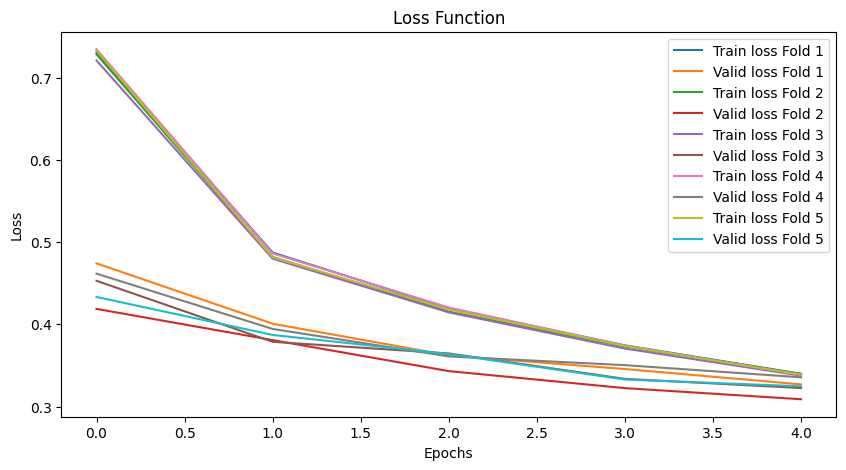

ValueError: ignored

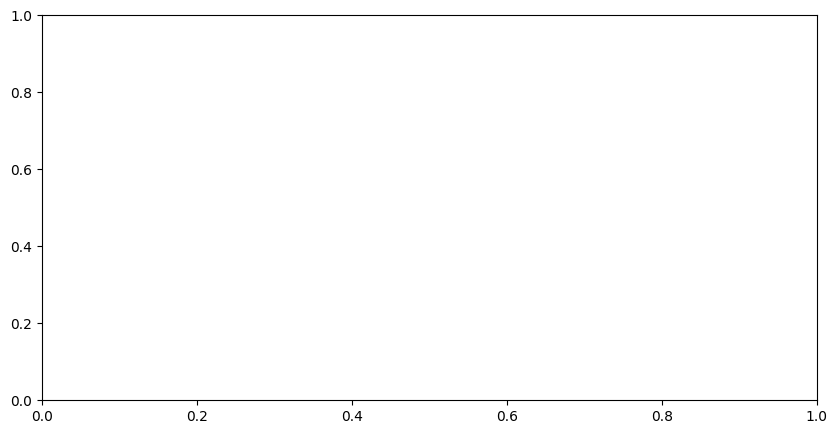

In [ ]:
from matplotlib._api.deprecation import MatplotlibDeprecationWarning
import matplotlib
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import KFold
import sklearn.metrics
import torch.nn.functional as F
import matplotlib.pyplot as plt  
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU is not available, using CPU instead')

class CNN(nn.Module):
    def __init__(self, num_hidden_layers, hidden_neurons):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(1024, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.relu5 = nn.ReLU()
        self.drop5 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(1024, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(1024, 47)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.drop4(x)
        x = self.fc3(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.drop5(x)
        x = self.fc4(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.drop6(x)
        x = self.fc5(x)
        return x

# Initialize the model, optimizer, and scheduler for the current fold and hidden neuron value
model = CNN(num_hidden_layers=5, hidden_neurons=1024).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

criterion = nn.CrossEntropyLoss()
# Start timer
start_time = time.time()
# Set up k-fold cross-validation
k = 5
num_epochs = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store accuracy and time for each fold
accuracy_list = []
time_list = []

# Initialize confusion matrix, precision, recall, and f1 score lists
cm_list = []
precision_list = []
recall_list = []
f1_list = []
train_loss_lists = []
valid_loss_lists = []

# Loop through each fold
for fold, (train_indices, test_indices) in enumerate(kf.split(train_data)):
    print(f'Fold {fold+1}:')
    train_subset = torch.utils.data.Subset(train_data, train_indices)
    val_subset = torch.utils.data.Subset(train_data, test_indices)  
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

    # Initialize the model, optimizer, and scheduler for the current fold
    model = CNN(num_hidden_layers=5, hidden_neurons=1024).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    criterion = nn.CrossEntropyLoss()
    train_loss_lists.append(train_loss_list)
    valid_loss_lists.append(valid_loss_list)


    # Initialize lists to store training and validation losses and accuracy
    train_loss_list = []
    valid_loss_list = []
    accuracy_list = []
    test_loss_list=[]

    # Train the model for the current fold
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)

        # Test the model on the validation set
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        valid_loss /= len(val_loader)
        valid_loss_list.append(valid_loss)
        
        accuracy = correct / total
        accuracy_list.append(accuracy)
        # Update the learning rate
        scheduler.step()
        

# Test the model on the test set for the current fold
model.eval()
test_loss = 0.0
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels += predicted.cpu().tolist()
        true_labels += labels.cpu().tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)


# Evaluate the model on the test set
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    test_loss = 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_loss_list.append(test_loss)
    test_accuracy = correct / total

# Calculate accuracy and time for the current fold
accuracy = 100.0 * correct / total
time_taken = time.time() - start_time
accuracy_list.append(accuracy)

import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(num_epochs)

plt.figure(figsize=(10, 5))

for i, (train_loss_list, valid_loss_list) in enumerate(zip(train_loss_lists, valid_loss_lists)):
    plt.plot(epochs, train_loss_list, label=f'Train loss Fold {i+1}')
    plt.plot(epochs, valid_loss_list, label=f'Valid loss Fold {i+1}')

plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


import numpy as np

# Plot loss function and accuracy graphs
epochs = np.arange(len(accuracy_list))  # Change this line
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss_list, label='Train loss')
plt.plot(epochs, valid_loss_list, label='Valid loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Calculate and print confusion matrix, F1 score, accuracy, precision, and recall
cm = confusion_matrix(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Confusion matrix:')
print(cm)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 score: {f1:.4f}')
# Print the results for the current fold
print(f'Train loss: {train_loss_list[-1]:.4f}')
print(f'Validation loss: {valid_loss_list[-1]:.4f}')
print(f'Test loss: {test_loss_list[-1]:.4f}')
print(f'Validation accuracy: {accuracy_list[-1]*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')
